# Data Component Use Case for Wave Power Calculation

## Introduction

Waves enhance sediment resuspension from the seabed and shorelines. Wave power is often correlated to shoreline erosion and is used to assess feasibility of renewable wave energy generation. This Jupyter notebook demonstrates how to use the [CSDMS Data Component](https://csdms.colorado.edu/wiki/DataComponents) to download surface wave properties from the WAVEWATCH III model (Booij et al., 1999) output for a given time period, interpolate it to a specific location, and calculate the wave power over time at that point. 


This notebook includes the following sections:
- [Initial Setup](#step0)  

  Import Python packages and create input/output folders.   
  <br>
  
- [Step 1: Download WAVEWATCH III Data](#step1)  
    
  Demonstrate how to download the data using the WAVEWATCH III data component in two different ways. The first method will use the [pymt-wavewatch3](#step1a) and the alternative second method will use the [bmi-wavewatch3](#step1b).
  <br>
  
- [Step 2: Interpolate Data to a Specific Location](#step2)  

  Interpolate the data onto a user-specified latitude and longitude.
  <br>
  
- [Step 3: Calculate Wave Power](#step3)

  Calculate a time series of the wave power at the user-specified latitude and longitude.
  <br>
    
- [Step 4: Visualize Results](#step4)  

  Visualize the results using time-series and rose diagram figures.
  <br>    

**Suggested Citation:** Undzis, B., Moriarty, J. M. (2023) Data Component Use Case for Wave Power Calculation, HydroShare, http://www.hydroshare.org/resource/b044425647e146229a778d59b164d7cf

**Run this notebook:** Please follow the instructions [here](https://github.com/bundzis/wavewatch3_usecase#data-component-use-case-for-wavewatch3-wave-power-calculation) to run this notebook on the local PC or the online platform.

<a id='step0'></a>

## Initial Setup

We will first import all the python packages and then create two folders for this notebook:
- **configuration file folder**: this folder includes a configuration file which will be used by the data component. In this example, we have prepared a configuration file ('ww3-config.toml') and put it in this folder.
- **results folder**: this folder stores the final results.

In [ ]:
# Import packages
import os
import warnings
warnings.simplefilter(action='ignore', category=(UserWarning,DeprecationWarning))

import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from windrose import WindroseAxes
import cftime

from pymt.models import WaveWatch3

In [ ]:
# Create folders 

study_area = 'gulf_of_mexico'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 


for folder in [config_dir, results_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

<a id='step1'></a>

## Step 1: Download Dataset 

### Background

Waves are important for sediment resuspension from seabeds and shorelines. Surface wave properties are often used in estimates of bed shear stress, wave power, and other parameters. 


In this example, we will use a data component to download data from WAVEWATCH III (WAVEWATCH III Production Hindcast, Multigrid: Feb 2005 to May 2019) on the Gulf of Mexico and NW Atlantic 4 min grid (shown below, image from [WAVEWATCH III website](https://polar.ncep.noaa.gov/waves/hindcasts/prod-multi_1.php)) which has a resolution of 4 arcminutes. The data will be interpolated to a location on the Northern Gulf of Mexico continental shelf (28.8&deg;N, 267.4&deg;E) for 17 March 2005 through 22 June 2005. More information about the dataset is available [here](https://polar.ncep.noaa.gov/waves/hindcasts/prod-multi_1.php). Downloaded data include:
- **Significant wave height (meters)**  
- **Peak wave period (seconds)**  
- **Peak wave direction (degrees)** 
    - *Wave direction is given in meteorological convention, with 0&deg; meaning that waves are coming from the north and 90&deg; meaning waves coming from the east. See page 93 of*  https://polar.ncep.noaa.gov/waves/wavewatch/manual.v5.16.pdf 
- **Windspeed in East-West direction (meters/second)**
    - *Positive values are wind coming from the east, negative values are wind coming from the west*  
- **Windspeed in the North-South direction (meters/second)**
    - *Positive values are wind coming from the north, negative values are wind coming from the south*
    
For more information on the different grids, see the WAVEWATCH III website: https://polar.ncep.noaa.gov/waves/hindcasts/prod-multi_1.php

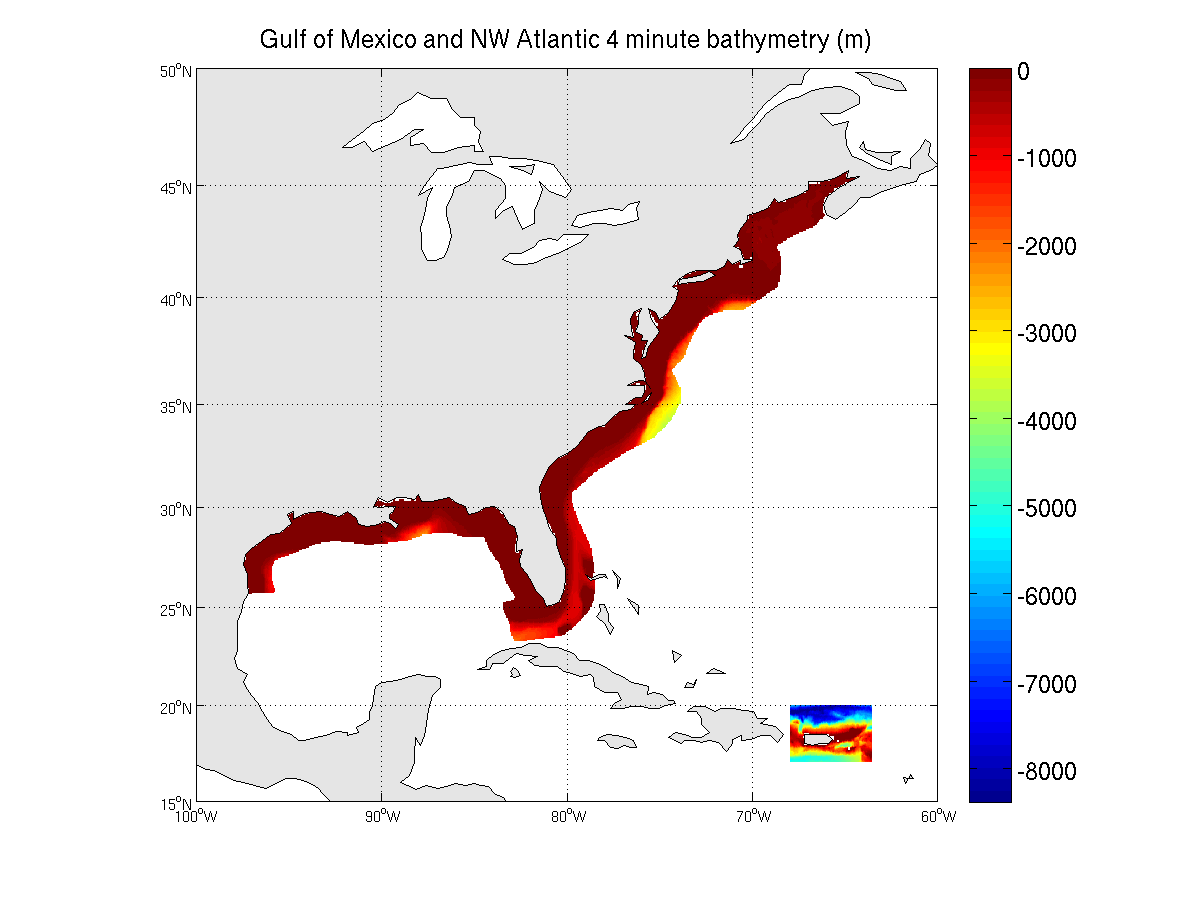

<a id='step1a'></a>
### Download data using pymt-wavewatch3
The 'ww3-config.toml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to intitialize the data component and how to use the variable and grid related methods of this data component to get the metadata as well as the data values.

In [ ]:
# Initialize WAVEWATCH III data component
ww3 = WaveWatch3()
ww3.initialize(os.path.join(config_dir, 'ww3-config.toml')) 

In [ ]:
# Get WAVEWATCH III variable information
for var_name in ww3.output_var_names:
    var_unit = ww3.var_units(var_name)
    var_location = ww3.var_location(var_name)
    var_type = ww3.var_type(var_name)
    var_grid = ww3.var_grid(var_name)
    var_itemsize = ww3.var_itemsize(var_name)
    var_nbytes = ww3.var_nbytes(var_name)
    print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

In [ ]:
# Get WAVEWATCH III grid information 
ww3_grid_ndim = ww3.grid_ndim(var_grid) 
ww3_grid_type = ww3.grid_type(var_grid)
ww3_grid_shape = ww3.grid_shape(var_grid)
ww3_grid_spacing = ww3.grid_spacing(var_grid)
ww3_grid_origin = ww3.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    ww3_grid_ndim, ww3_grid_type, ww3_grid_shape, ww3_grid_spacing, ww3_grid_origin))

In [ ]:
# Get WAVEWATCH III time info
ww3_start_time = ww3.start_time
ww3_end_time = ww3.end_time
ww3_time_step = ww3.time_step
ww3_time_unit = ww3.time_units
ww3_time_steps = int((ww3_end_time - ww3_start_time)/ww3_time_step) + 1

print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{}'.format(
    ww3_start_time, ww3_end_time, ww3_time_step, ww3_time_unit, ww3_time_steps))

In [ ]:
# Get WW3 variable data and plot (at the first time step)
fig1 = plt.figure(figsize=(19,25)) 
nrows, ncols = 3, 2
i = 1 #1

for var_name in ww3.output_var_names:
    ax1 = fig1.add_subplot(nrows, ncols, i)
    var_unit = ww3.var_units(var_name)
    
    # Get variable data    
    ww3_data = ww3.get_value(var_name)
    ww3_data_2D = ww3_data.reshape(ww3_grid_shape)

    # Get X, Y extent for plot
    min_y, min_x = ww3_grid_origin
    max_y = min_y + ww3_grid_spacing[0]*(ww3_grid_shape[0]-1)
    max_x = min_x + ww3_grid_spacing[1]*(ww3_grid_shape[1]-1)
    dy = ww3_grid_spacing[0]/2
    dx = ww3_grid_spacing[1]/2
    ww3_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]
    
    # Plot data
    im = ax1.imshow(ww3_data_2D, extent=ww3_extent, cmap='Blues') 
    ax1.set_title('{} ({})'.format(var_name,var_unit), size=20)
    ax1.set_xlabel('longitude (degrees)', size=18)
    ax1.set_ylabel('latitude (degrees)', size=18)
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label(label='{} ({})'.format(var_name,var_unit), size=18)
    
    i += 1

The plot above shows a snapshot in time of the different wave variables in the dataset. The time step shown is the 0th hour of 2005-03-01. The data for the whole grid is shown. The code automatically makes each subplot by looping through the different variables in WAVEWATCH III.

<a id='step1b'></a>

### Download data using bmi-wavewatch3

For this use case, we will not be coupling the Wavewatch3 data component to any pymt model components. So instead of using pymt-wavewatch3, we will use the bmi-wavewatch3 for data download and analysis. The bmi-wavewatch3 saves the time stamps of the data in a way that makes it easy to analyze the data and download additional data beyond the initial download. To start, we will re-download the WAVEWATCH III data using the API from the bmi-wavewatch3 package and specify a certain time period and point that we want to look at.

bmi-wavewatch3 pulls in one month of data at a time, and so this code specifies (a) the first month that we want to download; (b) the number of additional months to download (excluding the first month in (a)); (c) a specific start and end date. We will also specify (d) the WAVEWATCH III grid to obtain data from, i.e. the"Gulf of Mexico and NW Atlantic 4 min" grid; as well as (e) the latitude and longitude coordinates of the specific location to interpolate to. 

In [ ]:
# Load in the bmi-wavewatch3 data component 
from bmi_wavewatch3 import WaveWatch3

In [ ]:
# Specify the time period and the coordinates of interest

# Starting month
start_month = "2005-03-01"

# Number of months after to pull
num_months = 3 

# Start date (specific date to start data)
start_date = "2005-03-17"

# End date (specific date to end data)
end_date = "2005-06-22"

# Specify the grid
grid = 'at_4m' # 'at_4m' = Atlantic grid at 4 arcminute resolution; see figure in background section

# Specify the lat lon we want (the one point)
lat = 28.8 # degrees 
lon = 267.4 # degrees

In [ ]:
# Fetch the data for the time period we want (to start at) and the grid we want 
ww3 = WaveWatch3(start_month, grid=grid)

# Save the data to a list 
months = [ww3.data]

# Print info about the data
ww3.data

In [ ]:
# Add on the additional months
for _ in range(num_months):
    ww3.inc()
    months.append(ww3.data)

In [ ]:
# Concatenate all of the data together
ww3_all = xr.concat(months, dim='step')

# Create the time steps for these data
times = ww3_all.time + ww3_all.step

# Print these times
times.data[0], times.data[-1]

In [ ]:
# Pull out the steps for the time period we want 
steps = (times >= np.datetime64(start_date)) & (times <= np.datetime64(end_date))

In [ ]:
# Slice the steps to this time period 
sliced_data = ww3_all.isel(step=steps)

# Create the corresponding time steps 
sliced_times = sliced_data.time + sliced_data.step

# Print these time steps to confirm they are the time period we want
sliced_times.data[0], sliced_times.data[-1]

In [ ]:
# Plot the data for one time step
# Set the font size for the plots
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

# Make the figure
fig2, ax2 = plt.subplots(3,2, figsize=(19,25), constrained_layout=True)
time_stp2 = 0 # index of time step we want to plot

# Title the figure
fig2.suptitle('Wave Data at Time: ' + str(sliced_data.valid_time[time_stp2].values), fontweight='bold', fontsize=25)


# U wind
cs1 = ax2[0,0].contourf(sliced_data.longitude[:].values, sliced_data.latitude[:].values, sliced_data.u[time_stp2,:,:])
ax2[0,0].set_title('U Component of Wind (m/s)', size=20)
fig2.colorbar(cs1, ax=ax2[0,0]).set_label(label='Wind (m/s)', size=18)
ax2[0,0].set_xlabel('Longitude (degrees)', size=18)
ax2[0,0].set_ylabel('Latitude (degrees)', size=18)

# V wind
cs2 = ax2[0,1].contourf(sliced_data.longitude[:].values, sliced_data.latitude[:].values, sliced_data.v[time_stp2,:,:])
ax2[0,1].set_title('V Component of Wind (m/s)', size=20)
fig2.colorbar(cs2, ax=ax2[0,1]).set_label(label='Wind (m/s)', size=18)
ax2[0,1].set_xlabel('Longitude (degrees)', size=18)
ax2[0,1].set_ylabel('Latitude (degrees)', size=18)

# Significant wave height of combined wind waves and swell
cs3 = ax2[1,0].contourf(sliced_data.longitude[:].values, sliced_data.latitude[:].values, sliced_data.swh[time_stp2,:,:])
ax2[1,0].set_title('Significant Height of Combined Wind Waves and Swell (m)', size=20)
fig2.colorbar(cs3, ax=ax2[1,0]).set_label(label='Height (m)', size=18)
ax2[1,0].set_xlabel('Longitude (degrees)', size=18)
ax2[1,0].set_ylabel('Latitude (degrees)', size=18)

# Primary wave mean period
lev4 = np.arange(2,13,1)
cs4 = ax2[1,1].contourf(sliced_data.longitude[:].values, sliced_data.latitude[:].values, sliced_data.perpw[time_stp2,:,:], lev4)
ax2[1,1].set_title('Primary Wave Mean Period (seconds)', size=20)
fig2.colorbar(cs4, ax=ax2[1,1]).set_label(label='Period (s)', size=18)
ax2[1,1].set_xlabel('Longitude (degrees)', size=18)
ax2[1,1].set_ylabel('Latitude (degrees)', size=18)

# Primary wave direction 
cs5 = ax2[2,0].contourf(sliced_data.longitude[:].values, sliced_data.latitude[:].values, sliced_data.dirpw[time_stp2,:,:]) 
ax2[2,0].set_title('Primary Wave Direction (degrees)', size=20)
fig2.colorbar(cs5, ax=ax2[2,0]).set_label(label='Direction (deg)', size=18)
ax2[2,0].set_xlabel('Longitude (degrees)', size=18)
ax2[2,0].set_ylabel('Latitude (degrees)', size=18)

# Delete the extra set of axes
fig2.delaxes(ax2[2,1])

# Save the figure to the results folder
fig2.savefig(os.path.join(results_dir, 'all_wave_data01.png'))

<a id='step2'></a>

## Step 2: Interpolate the Data  

Now that we have downloaded the WAVEWATCH III data for the entire grid, let's interpolate the data to the specific location that we are interested in, which was specified above.

In [ ]:
# Copy and rename the original data to work with
wave_data = sliced_data.copy()

Below is the point in the ocean that we are interpolating the data onto.

In [ ]:
# Plot where our location of interest is relative to the WAVEWATCH III grid 
# Primary wave direction 
fig3, ax3 = plt.subplots(figsize=(7,5), constrained_layout=True)
ax3.set_title('Point X'  + ' (Lat: ' + str(lat) + u'\N{DEGREE SIGN}' + ' Lon: ' + str(lon) + u'\N{DEGREE SIGN}' + ')',
             fontweight='bold', fontsize=25)

cs6 = ax3.contourf(ww3.data.longitude[:].values, ww3.data.latitude[:].values, ww3.data.dirpw[5,:,:]) 
ax3.scatter(lon, lat, marker='x', color='orange', s=160, linewidth=3)
cbar6 = fig3.colorbar(cs6, ax=ax3).set_label(label='Wave Direction (degrees)', size=20)
ax3.set_xlabel('Longitude (degrees)', size=18)
ax3.set_ylabel('Latitude (degrees)', size=18)

# Save the figure to the results folder
fig3.savefig(os.path.join(results_dir, 'point_in_grid.png'))

In [ ]:
# Use the built-in xarray interpolation 
# to interpolate onto the given lat/lon
wave_data2 = wave_data.interp(latitude=lat, longitude=lon)

Now we need to interpolate out the NaNs in the time series.

In [ ]:
# Manually create a positonal index for the data 
ind = np.arange(0, len(wave_data2.step.values),1)

In [ ]:
# Make a new xarray dataset to fill with the data
wave_data4 = xr.Dataset(
            data_vars=dict(
                perpw=(['idx'], wave_data2.perpw.values),
                dirpw=(['idx'], wave_data2.dirpw.values),
                swh=(['idx'], wave_data2.swh.values),
                u=(['idx'], wave_data2.u.values),
                v=(['idx'], wave_data2.v.values),
            ),
            coords=dict(idx=(['idx'], ind),
                       time=(['idx'], sliced_times.values)),
            attrs=dict(description='Wave data. perpw = peak wave period (seconds), \
                       dirpw = peak wave direction (degrees), swh = significant wave height (m), \
                       u = u wind (m/s), v = v wind (m/s)'),
            )

In [ ]:
# Interpolate the NaNs out of this new dataset
wave_data5 = wave_data4.interpolate_na(dim='idx', method='linear', fill_value='extrapolate')

In [ ]:
# Check to make sure the interpolation worked
print(np.where(np.isnan(wave_data5.perpw.values)))

In [ ]:
# Plot the data  
fig4 = plt.subplots(figsize=(17,14)) 
gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])

# U and v wind
ax40 = plt.subplot(gs[0])
ax40.plot(wave_data5.time.values, wave_data5.u.values, linewidth=3, color='r', label='u wind')
ax40.plot(wave_data5.time.values, wave_data5.v.values, linewidth=5, color='b', label='v wind')
ax40.set_title('Interpolated Wave Data at Lat: ' + str(lat) + u'\N{DEGREE SIGN}' + ' Lon: ' + str(lon) + u'\N{DEGREE SIGN}',
              fontweight='bold', fontsize=25)
ax40.set_ylabel('Wind \nSpeed \n(m/s)', size=18, rotation=0, labelpad=30)
ax40.legend(fontsize=15)

# Significant wave height of combined wind waves and swell
ax41 = plt.subplot(gs[1], sharex=ax40)
ax41.plot(wave_data5.time.values, wave_data5.swh.values, linewidth=3, color='g')
plt.setp(ax41.get_xticklabels(), visible=False)
ax41.set_ylabel('Wave \nHeight \n(m)', size=18, rotation=0, labelpad=57)

# Primary wave mean period
ax42 = plt.subplot(gs[2], sharex=ax40)
ax42.plot(wave_data5.time.values, wave_data5.perpw.values, linewidth=3, color='orange')
plt.setp(ax42.get_xticklabels(), visible=False)
ax42.set_ylabel('Wave \nPeriod \n(s)', size=18, rotation=0, labelpad=60)

# Primary wave direction 
ax43 = plt.subplot(gs[3], sharex=ax40)
ax43.scatter(wave_data5.time.values, wave_data5.dirpw.values, linewidth=1, color='magenta')
ax43.set_ylabel('Wave \nDirection ' + u'\n(\N{DEGREE SIGN})', size=18, rotation=0, labelpad=45)

plt.xlabel('Date', fontsize=18)

# Remove vertical gap between subplots
plt.setp(ax40.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

# Save the figure to the results folder
plt.savefig(os.path.join(results_dir, 'wavevars_timeseries_01.png'))

<a id='step3'></a>

## Step 3: Calculate Wave Power

Wave power is useful because it is an indication of the amount of wave energy available at a certain point over time to drive different processes, such as shoreline erosion. Wave power can be calculated using the following equation (Thorpe 1999):  

$$P = \frac{\rho g^{2}TH^{2}}{32\pi} $$

where   
$P$ = wave power per meter of wave crest ($Wm^{-1}$)  
$\rho$ = density of seawater ($kg m^{-3}$)  
$g$ = acceleration due to gravity  ($m s^{-2}$)  
$T$ = wave period ($s$)  
$H$ = wave height ($m$)  

Now we will take the time series of surface wave characteristics that we just calculated for our study site, and use it to calculate a time series of the wave power at this location. 

In [ ]:
# Calculate wave power
# Assume some constants 
rho = 1025 # kg/m^3, density of seawater
g = 9.81 # m/s^2

# Use WAVEWATCH III data for wave properties
period = wave_data5.perpw.values # seconds
height = wave_data5.swh.values # meters

# Plug values into the wave power equation 
wave_power = (rho*(g**2)*period*(height**2))/(32*np.pi) # W/m

In [ ]:
# Plot a time series of the wave power
fig5, ax5 = plt.subplots(figsize=(17,5), constrained_layout=True)
ax5.plot(wave_data5.time.values, wave_power, color='purple', linewidth=3)
ax5.set_title('Wave Power (W/m)', size=20)
ax5.set_xlabel('Date', size=18)
ax5.set_ylabel('Wave \nPower \n(W/m)', size=18, rotation=0, labelpad=45)

# Save the figure to the results folder
fig5.savefig(os.path.join(results_dir, 'wavepower_timeseries_01.png'))

<a id='step4'></a>

## Step 4: Visualize Results 

This section visualizes the results in two ways: (1) as a time series with the other wave variables and (2) as a Rose diagram of wave power.

In [ ]:
# Make a time series plot of all of the variables, including wave power 
fig6 = plt.subplots(figsize=(17,14)) 
gs2 = gridspec.GridSpec(5, 1, height_ratios=[1,1,1,1,1])

# U and v wind
ax60 = plt.subplot(gs2[0])
ax60.plot(wave_data5.time.values, wave_data5.u.values, linewidth=3, color='r', label='u wind')
ax60.plot(wave_data5.time.values, wave_data5.v.values, linewidth=5, color='b', label='v wind')
ax60.set_title('Interpolated Wave Data at Lat: ' + str(lat) + u'\N{DEGREE SIGN}' + ' Lon: ' + str(lon) + u'\N{DEGREE SIGN}',
              fontweight='bold', fontsize=25)
ax60.set_ylabel('Wind \nSpeed \n(m/s)', size=18, rotation=0, labelpad=30)
ax60.legend(fontsize=15)

# Significant wave height of combined wind waves and swell
ax61 = plt.subplot(gs2[1], sharex=ax60)
ax61.plot(wave_data5.time.values, wave_data5.swh.values, linewidth=3, color='g')
plt.setp(ax61.get_xticklabels(), visible=False)
ax61.set_ylabel('Wave \nHeight \n(m)', size=18, rotation=0, labelpad=57)

# Primary wave mean period
ax62 = plt.subplot(gs2[2], sharex=ax60)
ax62.plot(wave_data5.time.values, wave_data5.perpw.values, linewidth=3, color='orange')
plt.setp(ax62.get_xticklabels(), visible=False)
ax62.set_ylabel('Wave \nPeriod \n(s)', size=18, rotation=0, labelpad=60)

# Primary wave direction 
ax63 = plt.subplot(gs2[3], sharex=ax60)
ax63.scatter(wave_data5.time.values, wave_data5.dirpw.values, linewidth=1, color='magenta')
plt.setp(ax63.get_xticklabels(), visible=False)
ax63.set_ylabel('Wave \nDirection ' + u'\n(\N{DEGREE SIGN})', size=18, rotation=0, labelpad=45)

# Wave power
ax64 = plt.subplot(gs2[4], sharex=ax40)
ax64.plot(wave_data5.time.values, wave_power, linewidth=3, color='purple')
ax64.set_ylabel('Wave \nPower \n(W/m)', size=18, rotation=0, labelpad=45)

plt.xlabel('Date', fontsize=18)

# Remove vertical gap between subplots
plt.setp(ax60.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

# Save the figure to the results folder
plt.savefig(os.path.join(results_dir, 'wavepower_timeseries_02.png'))

Running the next cell produces a Rose diagram for the timeseries of wave power and wave direction data shown above. The length of each bar and the concentric circles indicate the percentage of datapoints with waves coming from that direction (meteorological convention). The color indicates the wave power.

In [ ]:
# Make a rose diagram plot for wave power 
ax7 = WindroseAxes.from_ax()
bins_range = np.arange(0,12000,2000) # set the legend scale
ax7.bar(wave_data5.dirpw.values, wave_power, normed=True, bins=bins_range, opening=0.8, edgecolor='gray', cmap=cm.tab10)
ax7.set_yticks(np.arange(10, 50, step=10))
ax7.set_yticklabels(np.arange(10, 50, step=10))
ax7.legend(title='Wave Power (W/m)', loc='lower left', fontsize=15)
ax7.get_legend().get_title().set_fontsize('15')
ax7.set_title('Rose Diagram for Wave Power at Lat: ' + str(lat) + u'\N{DEGREE SIGN}' + ' Lon: ' + str(lon) + u'\N{DEGREE SIGN}',
             fontweight='bold', fontsize=15)

# Save the figure to the results folder
plt.savefig(os.path.join(results_dir, 'wavepower_rose_01.png'))

## References
Booij, N., Ris, R. C., and Holthuijsen, L. H. (1999). A third-generation wave model for coastal regions 1. Model description and validation. Journal of Geophysical Research, 104 (C4): 7649-7666. https://doi.org/10.1029/98JC02622

T.W. Thorpe, "A Brief Review of Wave Energy," UK Department of Trade and Industry, ETSU-R120, 25 May 99.
http://www.homepages.ed.ac.uk/shs/Wave%20Energy/Tom%20Thorpe%20report.pdf 